# Project Navigation Guidelines

In [2]:
'''
===================================================
Notebook naming convention for FindMeInside (FMI)
===================================================
Notebook name: [FMI] <Coord/Label> Alg - Exp<experiment_number>, Trial<trial_number>

===================================================
Folder/File naming convention
===================================================
# Folder categorised by Experiment (except Testing folder)
Folder name: Experiment<Experiment_number>

# Each Folder has N files.
# A file is either a 1)Unprocessed Dataset, 2)Processed Dataset, 3)Results dataset, 4) Notebook file
# Each experiment has N trials. (Adjustments to parameters/algorithm are made in each trial)
Files in folder will be named accordingly...

- Raw data point:             E<experiment_number>_Label/Location<location_identifier>_<date>v<version_number>
-- e.g. E1_LabelA_230320v1
- Raw data collection:        E<experiment_number>_All_Raw_<date>v<version_number>
-- e.g. E1_All_Raw_230320v1
- Processed data (if any):    E<experiment_number>_All_Proc_<date>v<version_number>
-- e.g. E1_All_Proc_230320v1
- Resampled data (if any):    E<experiment_number>_resampled_t<trial_number>
-- e.g. E1_resampled_t1
- Results data:               E<experiment_number>_<algorithm>_t<trial_number>_k<number_of_neighbours>
-- e.g. E1_KNN_t1_k37

===================================================
List of experiment(s) & description(s)
===================================================
>> Experiment 1 (Exp1) :11 Sensors {1, ..., 11} , 4 Location Labels {A,B,C,D}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 2 (Exp2) :11 Sensors {1, ..., 11} , 4 Location Coords {(x_A, y_A), ... (x_D, y_D)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 11-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 11-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 3 (Exp3) : 12 Sensors {0x1, ..., 0xC} , 12 Location Label {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Label (Classification Model)

>> Experiment 4 (Exp4) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Resampled 12-Sensor RSSI Signature (100-x%)
>> Tested Data: Resampled 12-Sensor RSSI Signature (x%)
>> Output: Location Coords (Regression Model)

>> Experiment 5 (Exp5) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 6 (Exp6) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via Cypress BLE PC App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Resampled 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

>> Experiment 7 (Exp7) : 12 Sensors {0x1, ..., 0xC} , 12 Location Coords {(x_1,y_1), ... , (x_12, y_12)}
>> Data collected via FindMeInside Phone App
>> Trained Data: Averaged 12-Sensor RSSI Signature for 12 Locations
>> Tested Data: Averaged 12-Sensor RSSI Signature
>> Output: Location Coords (Regression Model)

'''
None

# Trial Description

In [3]:
exp = 6
trial = 1
'''
Trial 1
Algorithms use calcLocation mechanic
Resampling done within time period of 2s.
RSS fingerprint (TRAIN):
    for each location, find the average RSS value from each beacon
    (excluding 0 values)
'''
None

# Core Libraries

In [4]:
import pandas as pd #from pandas import read_csv, pivot_table
import numpy as np
import math
import operator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import preprocessing

import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

# [Exploratory Data Analysis]

# Prepare/Load Relevant Dataset

In [5]:
# Read csv file into dataframe.
csvfile = pd.read_csv('E6_All_Proc_230320v1.csv')
relDf = pd.DataFrame(csvfile)
# print(relDf)
relDf.columns = relDf.columns.str.strip() #strip unintended whitespaces

# print("Columns: ", relDf.columns)
relDf = relDf[['Date','Time', 'ID2', 'RSSI', 'Location']] #select relevant columns
# df = df.drop(columns=['Type', 'ID0', 'ID1', 'Sensor Data', 'Temperature', 'Humidity', 'Raw Data'])
print(relDf)

          Date       Time      ID2  RSSI Location
0      16/3/20   15:14:49   0x0001   192      1,1
1      16/3/20   15:14:49   0x0003   177      1,1
2      16/3/20   15:14:49   0x0004   179      1,1
3      16/3/20   15:14:50   0x0002   189      1,1
4      16/3/20   15:14:51   0x0008   177      1,1
...        ...        ...      ...   ...      ...
50620  19/3/20   15:48:23   0x0006   177    13,19
50621  19/3/20   15:48:24   0x0008   180    13,19
50622  19/3/20   15:48:24   0x0005   177    13,19
50623  19/3/20   15:48:24   0x0009   180    13,19
50624  19/3/20   15:48:24   0x0003   180    13,19

[50625 rows x 5 columns]


# Resample/Reshape Dataset

In [6]:
# Preparation for Date/Time Differences
# ----------------------------------------

# Combine date and time to datetime
readings = relDf.copy()
readings['Datetime'] = pd.to_datetime(readings['Date'].apply(str)+' '+readings['Time']) #create new Datetime field
dateTime = readings['Datetime']
readings = readings.drop(columns=['Datetime'])
readings.insert(0, 'Datetime', dateTime)
readings = readings.drop(columns=['Date','Time'])
readings.tail()

from datetime import datetime as dt
earliestDate = readings.Datetime.dt.date.min()
print(readings.Datetime.dt.date.iloc[-1])
print(earliestDate - readings.Datetime.dt.date.iloc[-1])

# Function that expresses timestamps in seconds.
def time_to_sec(timeArray):
    timeSecArray = []
    for i in range(len(timeArray)):
        seconds = (timeArray[i].hour * 60 + timeArray[i].minute) * 60 + timeArray[i].second
        timeSecArray.append(seconds)
    return(timeSecArray)

# Function that calculates day difference between dates in seconds
def date_to_sec(dateArray):
    dateSecArray = []
    for i in range(len(dateArray)):
        dayDiff = dateArray[i] - earliestDate
        dateSecArray.append(dayDiff.total_seconds())
#     print(i)
    return(dateSecArray)


readings['DateSec'] = date_to_sec(readings.Datetime.dt.date)
readings['TimeSec'] = time_to_sec(readings.Datetime.dt.time)
readings['DatetimeSec'] = readings['DateSec'] + readings['TimeSec']
readings = readings[['DatetimeSec', 'ID2', 'RSSI', 'Location']]

# pd.set_option('display.max_columns', 10)
# pd.set_option('display.min_rows', 50)
# pd.set_option('display.width', 500)

readings.DatetimeSec = (readings.DatetimeSec - readings.DatetimeSec.min()) // 2
time_diff_btw_rows = readings.DatetimeSec.diff().fillna(0)
# print(time_diff_btw_rows)
time_diff_btw_rows -= (time_diff_btw_rows > 1) & (readings.DatetimeSec % 2 > 0)
readings.DatetimeSec -= (time_diff_btw_rows - 1).clip(lower=0).cumsum()
readings.ID2 = readings.ID2.transform(lambda hexadecimal: int(hexadecimal, 16))
resampled_readings = readings.groupby(["DatetimeSec", "Location", "ID2"]).mean().reset_index()
pivoted_readings = pd.pivot_table(resampled_readings, values="RSSI", columns=["ID2"], index=["DatetimeSec", "Location"]).fillna(0)

writeFile = True
if (writeFile == True):
    pivoted_readings.to_csv('E6_resampled_T1.csv')
    print("FILE WRITTEN")

pivoted_readings.head()

2020-03-19
-3 days, 0:00:00
FILE WRITTEN


,ID2,1,2,3,4,5,6,7,8,9,10,11,12
DatetimeSec,Location,,,,,,,,,,,,
0.0,"1,1",192.0,189.0,177.0,179.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,"1,1",193.0,182.0,180.0,0.0,177.0,0.0,0.0,177.0,177.0,0.0,177.0,0.0
2.0,"1,1",191.0,191.0,185.0,184.0,177.0,177.0,0.0,177.0,0.0,177.0,0.0,177.0
3.0,"1,1",195.0,192.0,184.0,182.0,177.0,177.0,177.0,177.0,0.0,0.0,177.0,177.0
4.0,"1,1",194.0,193.0,184.0,187.0,0.0,0.0,177.0,178.0,0.0,0.0,0.0,177.0


In [7]:
resampledDS = pd.read_csv('E6_resampled_T1.csv')
tempSeries = resampledDS['Location']
resampledDS = resampledDS.drop(columns=['Location', 'DatetimeSec'])
resampledDS["Location"] = tempSeries
resampledDS.head()
lastIndex = len(resampledDS)
numCol = len(resampledDS.columns)

ips_data = resampledDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label = resampledDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_test = ips_data.to_numpy()
y_test = ips_label.to_numpy()
print(len(y_test))
y_test

5412


array([['1,1'],
       ['1,1'],
       ['1,1'],
       ...,
       ['13,19'],
       ['13,19'],
       ['13,19']], dtype=object)

# Load Train Set

In [141]:
trainsetDS = pd.read_csv('E5_resampled_T1.csv') #E5 resampled: for each location, take average of non-zero beacon values
tempSeries = trainsetDS['Location']
trainsetDS = trainsetDS.drop(columns=['Location'])
trainsetDS["Location"] = tempSeries
trainsetDS.head()

ips_data2 = trainsetDS.iloc[:lastIndex, :numCol-1]
# print(ips_data)
ips_label2 = trainsetDS.iloc[:lastIndex, numCol-1:]
# print(ips_labels)

X_train = ips_data2.to_numpy()
y_tr = y_train.copy()
y_train = ips_label2.to_numpy()
print(y_tr)
y_train = y_train.reshape(len(y_train),)
print(len(y_train))
y_train

k_value_rootN = math.ceil(math.sqrt(len(X_train)))
k_value_cubeN = math.ceil(len(X_train)**(1/3))
print("k_value_rootN: ", k_value_rootN)
print("k_value_cubeN: ", k_value_cubeN)
print("X_test: ", X_test)
print("y_test: ", y_test)
print("X_train: ", X_train)
# print("y_test: ", y_test)
print("y_train: ", y_train)

['1,1' '1,13' '1,19' '1,7' '13,1' '13,13' '13,19' '13,7' '7,1' '7,13'
 '7,19' '7,7']
12
k_value_rootN:  4
k_value_cubeN:  3
X_test:  [[192. 189. 177. ...   0.   0.   0.]
 [193. 182. 180. ...   0. 177.   0.]
 [191. 191. 185. ... 177.   0. 177.]
 ...
 [  0.   0. 180. ... 183. 187. 197.]
 [  0. 178.   0. ...   0. 192. 197.]
 [  0. 177. 180. ...   0. 193. 197.]]
y_test:  [['1,1']
 ['1,1']
 ['1,1']
 ...
 ['13,19']
 ['13,19']
 ['13,19']]
X_train:  [[193.2009132 189.4528302 183.5311778 182.9371859 177.5664336 177.
  177.3631841 177.7402597 177.        177.        177.        177.       ]
 [177.        177.0318471 177.918429  189.4638404 178.3541667 178.4257703
  192.5426009 183.5602094 180.2565321 180.5214592 187.3544018 179.302521 ]
 [  0.        177.        177.        181.2573529 178.1125828 177.0075949
  188.4855234 178.8333333 178.8753463 193.2039604 189.4307692 188.3285372]
 [180.2261905 179.1229508 180.2915663 193.5610973 187.3562092 180.7564103
  182.1006865 178.8715365 178.2581454 17

# Parameter Optimisation

# KNN Algorithm - Distance Calculation

In [11]:
#Function calculates euclidean distance between two n-dimensional data instances 
def euclideanDistance(instance1, instance2):
    #handles if instances are lists or tuples:
    instance1 = np.array(instance1) 
    instance2 = np.array(instance2)
    
    '''
    https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html
    uses 2-norm frobenius norm and returns euclidean distance
    '''
    return np.linalg.norm(instance1 - instance2) #euclidean distance

# KNN Algorithm - Determining Neighbours

In [12]:
#Function finds nearest neighbours; nearest -> smallest euclidean distance
def get_neighbors(training_set, 
                  labels, 
                  test_instance, 
                  k, 
                  distance=euclideanDistance):
    """
    get_neighbors calculates a list of the k nearest neighbors
    of an instance 'test_instance'.
    The list neighbors contains 3-tuples with  
    (index, dist, label)
    where
    index    is the index from the training_set, 
    dist     is the distance between the test_instance and the 
             instance training_set[index]
    distance is a reference to a function used to calculate the 
             distances
    """
    distances = [] #empty distance array
    
    #calculates euclidean distance between test_instance and ALL other instances in training_set
    for index in range(len(training_set)):
        dist = euclideanDistance(test_instance, training_set[index])
        distances.append((training_set[index], dist, labels[index]))
    distances.sort(key=lambda x: x[1])
    neighbors = distances[:k]
    return neighbors # The list neighbors contains 3-tuples with (index, dist, label)

In [13]:
# Get Neighbours
outArray = []
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_rootN, 
                              distance=euclideanDistance)
#     print(i,
#           X_test[i],
#           y_test[i],
#           neighbors)
    
    outArray.append([i,
          X_test[i],
          y_test[i],
          neighbors])

out_df = pd.DataFrame(outArray, columns=['i', 'X_test', 'y_test', 'neighbours'])
out_df.head()
# out_df.tail()

,i,X_test,y_test,neighbours
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","[1,1]","[([193.2009132, 189.4528302, 183.5311778000000..."
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","[1,1]","[([193.2009132, 189.4528302, 183.5311778000000..."
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","[1,1]","[([193.2009132, 189.4528302, 183.5311778000000..."
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","[1,1]","[([193.2009132, 189.4528302, 183.5311778000000..."
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","[1,1]","[([193.2009132, 189.4528302, 183.5311778000000..."


In [14]:
from collections import Counter
#LOC: outputs for each [x,y] in label, 
#     where (x_n1, y_n1) rep x and y coord of 1st neighbour resp
#     x_out = sum(x_n1, ... x_N) / N, where total neighbours = N
def calcLocation(neighbours): 
    x_out = 0
    y_out = 0
    totalNeighbours = len(neighbours)
    for neighbour in neighbours:
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
#         print("neighbour label: ", labeltuple)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb
        y_out += y_nb
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
    return ((x_out/totalNeighbours) , (y_out/totalNeighbours))

In [15]:
print("NON-WEIGHTED POSITION KNN\n")
k_value_knn = k_value_rootN
for i in range(5):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocation(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    print("----------------------------")

NON-WEIGHTED POSITION KNN

test location:  (1, 1)
calculalated location:  (5.5, 2.5)
distance error:  4.743416490252569
----------------------------
test location:  (1, 1)
calculalated location:  (7.0, 2.5)
distance error:  6.18465843842649
----------------------------
test location:  (1, 1)
calculalated location:  (7.0, 2.5)
distance error:  6.18465843842649
----------------------------
test location:  (1, 1)
calculalated location:  (5.5, 2.5)
distance error:  4.743416490252569
----------------------------
test location:  (1, 1)
calculalated location:  (5.5, 2.5)
distance error:  4.743416490252569
----------------------------


In [18]:
k_value_knn = k_value_cubeN
writeKNN = True
fileNameKNN = 'E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(k_value_knn)+'.csv'
resultsKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_knn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocation(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocation(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    calcLocationRes = calcLocation(neighbors)
    locArray.append(calcLocationRes)
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationRes))


resultsKNN['index'] = indexArray
resultsKNN['data'] = dataArray
resultsKNN['pred_location'] = locArray
resultsKNN['label'] = labelArray 
resultsKNN['error'] = errorArray

if (writeKNN == True):
    resultsKNN.to_csv(fileNameKNN, index=False)
    print("File "+fileNameKNN+" has been written.")
resultsKNN.head(20)

File E6_KNN_T1_k3.csv has been written.


,index,data,pred_location,label,error
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","(5.0, 3.0)","1,1",4.472136
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","(7.0, 1.0)","1,1",6.000000
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","(7.0, 1.0)","1,1",6.000000
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","(7.0, 1.0)","1,1",6.000000
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","(7.0, 1.0)","1,1",6.000000
5,5,"[194.0, 190.0, 185.0, 183.0, 177.0, 0.0, 177.0...","(5.0, 5.0)","1,1",5.656854
6,6,"[194.0, 191.0, 188.0, 183.0, 178.0, 0.0, 177.0...","(5.0, 3.0)","1,1",4.472136
7,7,"[193.0, 192.0, 185.0, 184.0, 0.0, 0.0, 177.0, ...","(5.0, 5.0)","1,1",5.656854
8,8,"[194.0, 0.0, 180.0, 0.0, 178.0, 0.0, 0.0, 177....","(7.0, 7.0)","1,1",8.485281
9,9,"[191.0, 185.0, 181.0, 181.0, 0.0, 0.0, 177.0, ...","(5.0, 5.0)","1,1",5.656854


# Weighted KNN

# Distance Weighted KNN

In [147]:
def calcLocationDistW(neighbours): 
    x_out = 0
    y_out = 0
    total_dist = 0
#     cnt = 1
    for neighbour in neighbours:
#         print("Neighour #: ", cnt)
        # handle label (str) to tuple(int, int)
        labeltuple = neighbour[2]
        labeltuple = tuple(map(int, labeltuple.split(',')))
        # distance
        dist_nb = neighbour[1]
        weightDen = dist_nb**2
        total_dist += ( 1 / (0.01 + weightDen) ) #adjusted weight : 1/(d)
#         print("Neighbour distance: ", dist_nb)
#         print("Total distance: ", total_dist)
        x_nb = labeltuple[0]
        y_nb = labeltuple[1]
#         print("x_nb: ", x_nb)
#         print("y_nb: ", y_nb)
        x_out += x_nb*( 1 / (0.01 + weightDen) ) 
        y_out += y_nb*( 1 / (0.01 + weightDen) ) 
#         print("x_out: ", x_out)
#         print("y_out: ", y_out)
#         cnt += 1
    return ( (x_out/(1 if total_dist == 0 else total_dist)) ,
             (y_out/(1 if total_dist == 0 else total_dist)) )


In [148]:
k_value_dwknn = 3
testRange = 20
for i in range(testRange):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
#     print("X_test[i]: ", X_test[i])
#     print("Neighbour: ", neighbors[0][0])
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
    print("test location: ", testPosTuple)
    print("calculalated location: ", calcLocationDistW(neighbors))
    print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    print("---------------------------------------------------------")

test location:  (1, 1)
calculalated location:  (5.015408899254314, 2.9581946576664913)
distance error:  4.46744165552549
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (6.9853294998328535, 1.0)
distance error:  5.9853294998328535
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (6.982191295027751, 1.0)
distance error:  5.982191295027751
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (6.988050116859274, 1.0)
distance error:  5.988050116859274
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (6.9726025274643195, 1.0)
distance error:  5.9726025274643195
---------------------------------------------------------
test location:  (1, 1)
calculalated location:  (4.934016801871917, 4.941760542521522)
distance error:  5.569018259261691
------------------------------------

In [152]:
k_value_dwknn = 1
writeDWKNN = True
fileNameDWKNN = 'E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(k_value_dwknn)+'.csv'
resultsDWKNN = pd.DataFrame(0, index=range(len(X_test)), columns=['index', 'data', 'pred_location', 'label', 'error'])

indexArray = []
dataArray = []
locArray = []
labelArray = []
errorArray = []
for i in range(len(X_test)):
    neighbors = get_neighbors(X_train, 
                              y_train, 
                              X_test[i], 
                              k_value_dwknn, 
                              distance=euclideanDistance)
    
    testPosTuple = tuple(map(int, y_test[i][0].split(',')))
#     print("test location: ", testPosTuple)
#     print("calculalated location: ", calcLocationDistW(neighbors))
#     print("distance error: ", euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))
    
    indexArray.append(i)
    dataArray.append(X_test[i])
    locArray.append(calcLocationDistW(neighbors))
    labelArray.append(y_test[i][0])
    errorArray.append(euclideanDistance(testPosTuple, calcLocationDistW(neighbors)))


resultsDWKNN['index'] = indexArray
resultsDWKNN['data'] = dataArray
resultsDWKNN['pred_location'] = locArray
resultsDWKNN['label'] = labelArray 
resultsDWKNN['error'] = errorArray

if (writeDWKNN == True):
    resultsDWKNN.to_csv(fileNameDWKNN, index=False)
    print("File "+fileNameDWKNN+" has been written.")
    
resultsDWKNN.head(20)

File E6_DWKNN_T1_k1.csv has been written.


,index,data,pred_location,label,error
0,0,"[192.0, 189.0, 177.0, 179.0, 0.0, 0.0, 0.0, 0....","(1.0, 1.0)","1,1",0.0
1,1,"[193.0, 182.0, 180.0, 0.0, 177.0, 0.0, 0.0, 17...","(1.0, 1.0)","1,1",0.0
2,2,"[191.0, 191.0, 185.0, 184.0, 177.0, 177.0, 0.0...","(1.0, 1.0)","1,1",0.0
3,3,"[195.0, 192.0, 184.0, 182.0, 177.0, 177.0, 177...","(1.0, 1.0)","1,1",0.0
4,4,"[194.0, 193.0, 184.0, 187.0, 0.0, 0.0, 177.0, ...","(1.0, 1.0)","1,1",0.0
5,5,"[194.0, 190.0, 185.0, 183.0, 177.0, 0.0, 177.0...","(1.0, 1.0)","1,1",0.0
6,6,"[194.0, 191.0, 188.0, 183.0, 178.0, 0.0, 177.0...","(1.0, 1.0)","1,1",0.0
7,7,"[193.0, 192.0, 185.0, 184.0, 0.0, 0.0, 177.0, ...","(1.0, 1.0)","1,1",0.0
8,8,"[194.0, 0.0, 180.0, 0.0, 178.0, 0.0, 0.0, 177....","(13.0, 1.0)","1,1",12.0
9,9,"[191.0, 185.0, 181.0, 181.0, 0.0, 0.0, 177.0, ...","(1.0, 1.0)","1,1",0.0


# Data Analysis via Visualisation

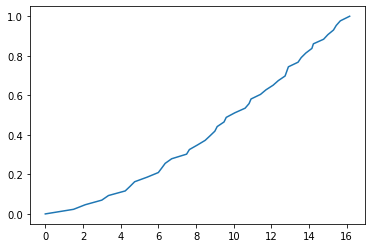

In [53]:
DataKNN = pd.read_csv('E6_KNN_T1_k4.csv')
# Find the unique values

# unique_values = np.sort(pd.Series)
# Make the rank array for these sorted and unique values in the dataset -
# ranks = np.arange(0,len(unique_values))/(len(unique_values)-1)
# Plot unique_values vs ranks

error = DataKNN['error']
## sort the unique values using pandas unique function
knn_error = np.sort(error.unique())
knn_cdf = np.arange(0,len(knn_error),step=1)/(len(knn_error)-1)

## plotting    
plt.plot(knn_error,knn_cdf)
plt.show()

Plotting from...
E6_KNN_T1_k1.csv E6_KNN_T1_k3.csv E6_KNN_T1_k4.csv E6_KNN_T1_k4.csv
E6_DWKNN_T1_k1.csv E6_DWKNN_T1_k3.csv E6_DWKNN_T1_k4.csv E6_DWKNN_T1_k4.csv


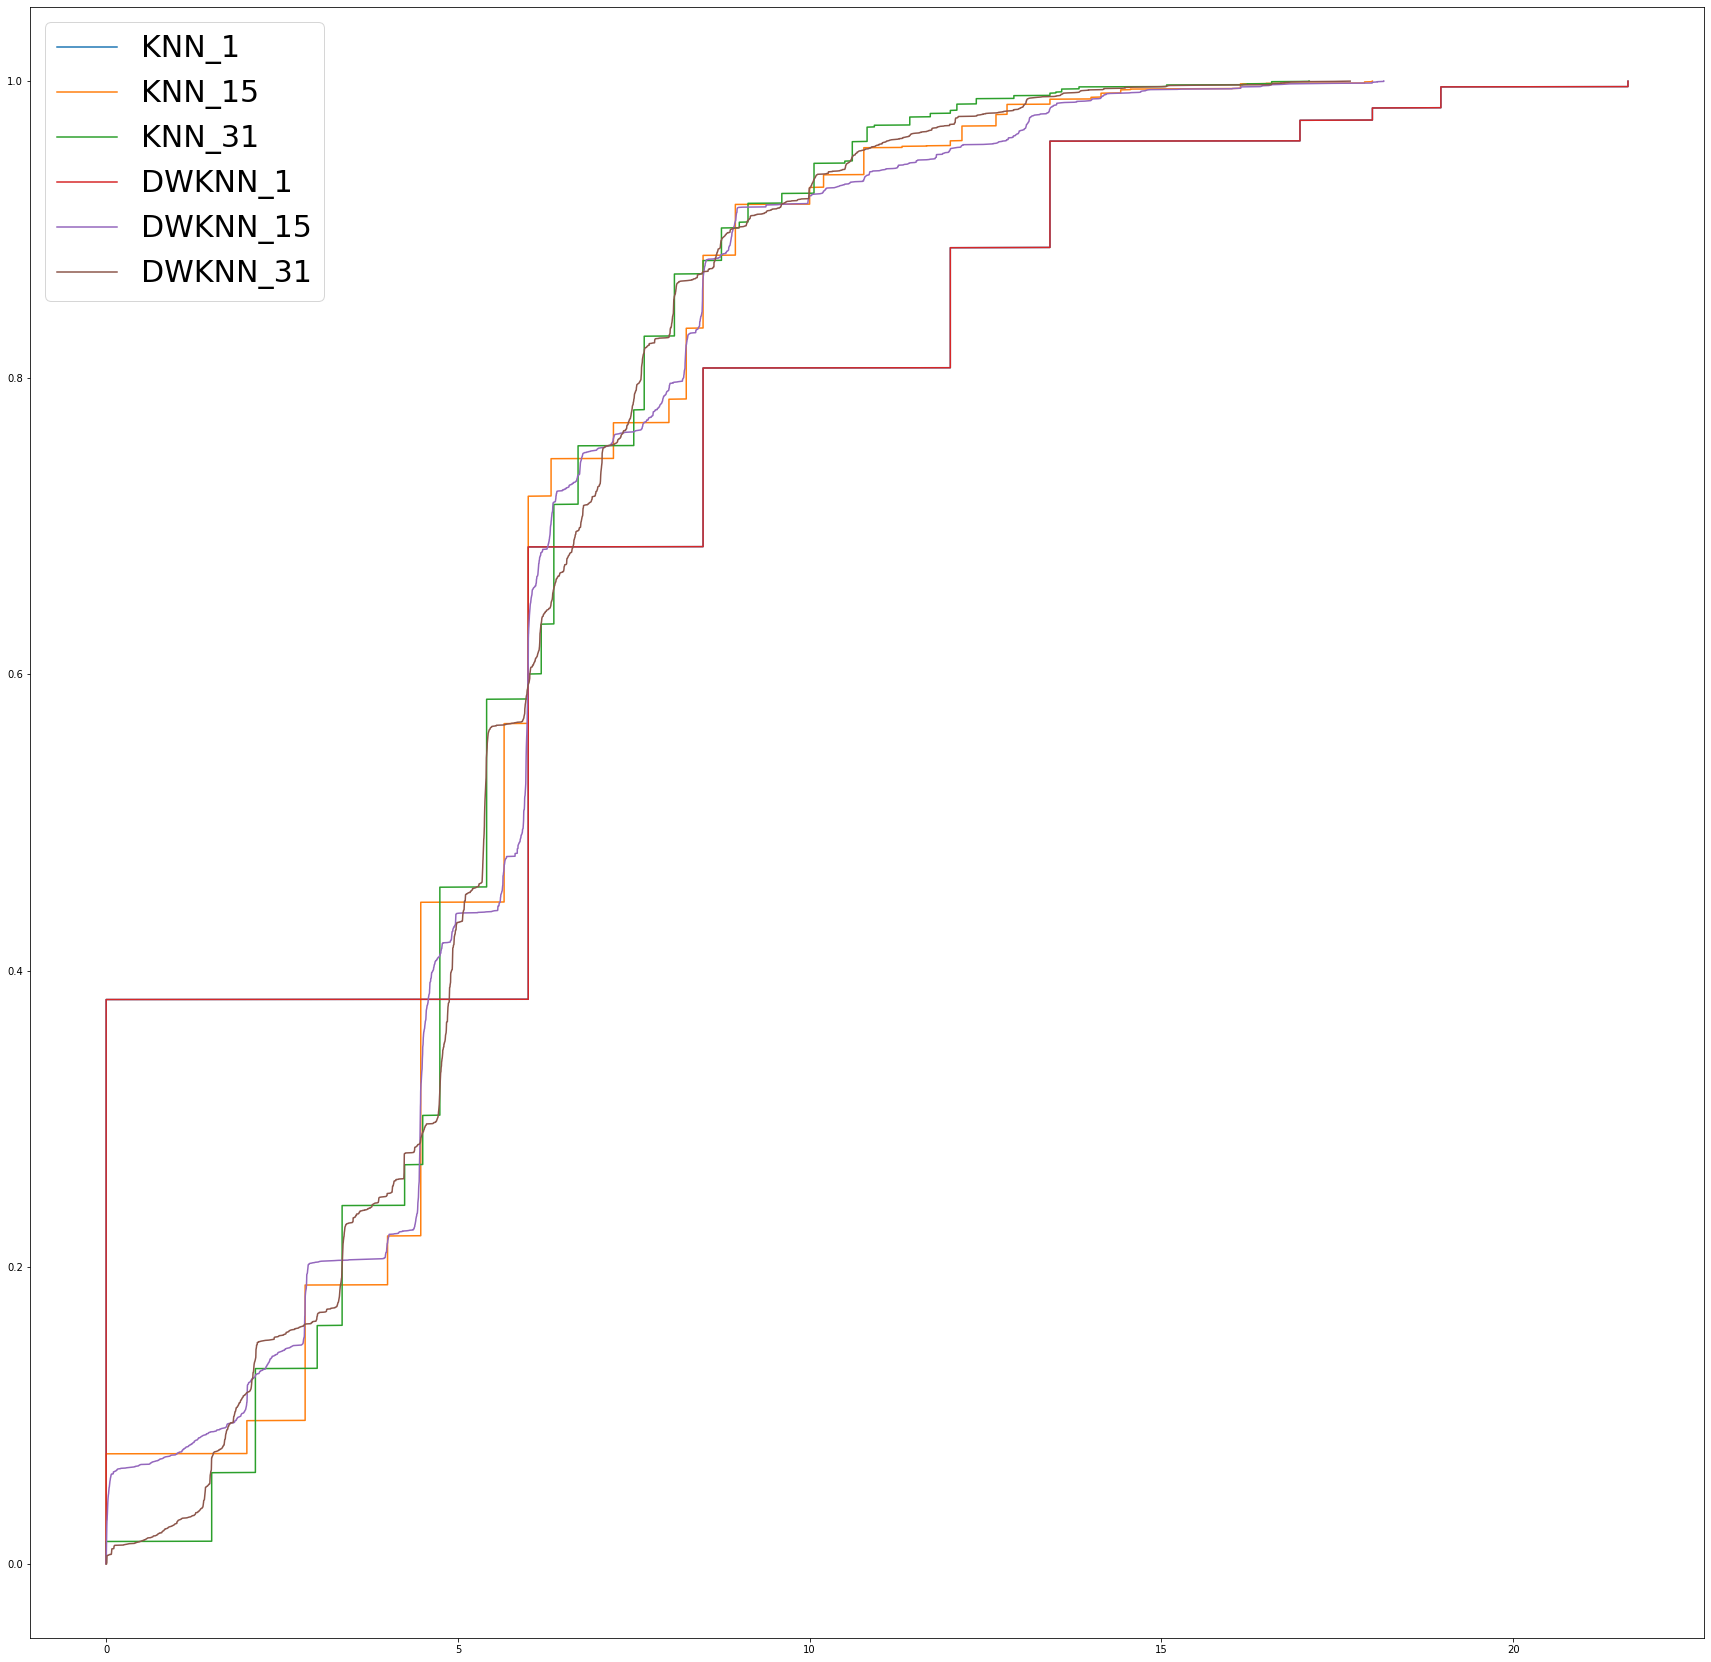

In [153]:
kvalList = [1, 3, 4]
KNN_kcomp1File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[0])+'.csv')
KNN_kcomp2File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[1])+'.csv')
KNN_kcomp3File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
KNN_kcomp4File = ('E'+str(exp)+'_KNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')

DWKNN_kcomp1File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[0])+'.csv')
DWKNN_kcomp2File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[1])+'.csv')
DWKNN_kcomp3File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
DWKNN_kcomp4File = ('E'+str(exp)+'_DWKNN_'+'T'+str(trial)+'_k'+str(kvalList[2])+'.csv')
errorCDFPlot = ('E'+str(exp)+'_errorCDFPlot_T'+str(trial)+'.png')

print("Plotting from...")
print(KNN_kcomp1File, KNN_kcomp2File, KNN_kcomp3File, KNN_kcomp4File)
print(DWKNN_kcomp1File, DWKNN_kcomp2File, DWKNN_kcomp3File, DWKNN_kcomp4File)


fig= plt.figure(figsize=(30,30))


KNN_kcomp1 = pd.read_csv(KNN_kcomp1File)
errorDf = pd.DataFrame(index = range(len(KNN_kcomp1.values))) #init errorDf

error = KNN_kcomp1['error']
errorDf["knn_k"+str(kvalList[0])+"_error"] = error
knn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp1_error),step=1)/(len(knn_kcomp1_error)-1)
## plotting    
plt.plot(knn_kcomp1_error,cdf, label = "KNN_1")

KNN_kcomp2 = pd.read_csv(KNN_kcomp2File)
error = KNN_kcomp2['error']
errorDf["knn_k"+str(kvalList[1])+"_error"] = error
knn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp2_error),step=1)/(len(knn_kcomp2_error)-1)
## plotting    
plt.plot(knn_kcomp2_error,cdf, label = "KNN_15")

KNN_kcomp3 = pd.read_csv(KNN_kcomp3File)
error = KNN_kcomp3['error']
errorDf["knn_k"+str(kvalList[2])+"_error"] = error
knn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(knn_kcomp3_error),step=1)/(len(knn_kcomp3_error)-1)
## plotting    
plt.plot(knn_kcomp3_error,cdf, label = "KNN_31")

# KNN_kcomp4 = pd.read_csv(KNN_kcomp4File)
# error = KNN_kcomp4['error']
# errorDf["knn_k"+str(kvalList[3])+"_error"] = error
# knn_kcomp4_error = np.sort(error)
# cdf = np.arange(0,len(knn_kcomp4_error),step=1)/(len(knn_kcomp4_error)-1)
# ## plotting    
# plt.plot(knn_kcomp4_error,cdf, label = "KNN_62")

#-------------

DWKNN_kcomp1 = pd.read_csv(DWKNN_kcomp1File)
error = DWKNN_kcomp1['error']
errorDf["dwknn_k"+str(kvalList[0])+"_error"] = error
dwknn_kcomp1_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp1_error),step=1)/(len(dwknn_kcomp1_error)-1)
## plotting    
plt.plot(dwknn_kcomp1_error,cdf, label = "DWKNN_1")

DWKNN_kcomp2 = pd.read_csv(DWKNN_kcomp2File)
error = DWKNN_kcomp2['error']
errorDf["dwknn_k"+str(kvalList[1])+"_error"] = error
dwknn_kcomp2_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp2_error),step=1)/(len(dwknn_kcomp2_error)-1)
## plotting    
plt.plot(dwknn_kcomp2_error,cdf, label = "DWKNN_15")

DWKNN_kcomp3 = pd.read_csv(DWKNN_kcomp3File)
error = DWKNN_kcomp3['error']
errorDf["dwknn_k"+str(kvalList[2])+"_error"] = error
dwknn_kcomp3_error = np.sort(error)
cdf = np.arange(0,len(dwknn_kcomp3_error),step=1)/(len(dwknn_kcomp3_error)-1)
## plotting    
plt.plot(dwknn_kcomp3_error,cdf, label = "DWKNN_31")

# DWKNN_kcomp4 = pd.read_csv(DWKNN_kcomp4File)
# error = DWKNN_kcomp4['error']
# errorDf["dwknn_k"+str(kvalList[3])+"_error"] = error
# dwknn_kcomp4_error = np.sort(error)
# cdf = np.arange(0,len(dwknn_kcomp4_error),step=1)/(len(dwknn_kcomp4_error)-1)
# ## plotting    
# plt.plot(dwknn_kcomp4_error,cdf, label = "DWKNN_62")


# additional plot params
plt.legend(loc='best', fontsize = 30)
plt.savefig(errorCDFPlot)


Median Error:
knn_k1_error      6.000000
knn_k3_error      5.656854
knn_k4_error      5.408327
dwknn_k1_error    6.000000
dwknn_k3_error    5.932296
dwknn_k4_error    5.377177
dtype: float64

0.75 Quantile Error:
knn_k1_error      8.485281
knn_k3_error      7.211103
knn_k4_error      6.708204
dwknn_k1_error    8.485281
dwknn_k3_error    6.855622
dwknn_k4_error    7.052724
Name: 0.75, dtype: float64

Max Error:
knn_k1_error      21.633308
knn_k3_error      18.000000
knn_k4_error      17.102631
dwknn_k1_error    21.633308
dwknn_k3_error    18.162123
dwknn_k4_error    17.684676
dtype: float64

Std Error:
knn_k1_error      5.228867
knn_k3_error      2.938561
knn_k4_error      2.622576
dwknn_k1_error    5.228867
dwknn_k3_error    3.076499
dwknn_k4_error    2.781871
dtype: float64


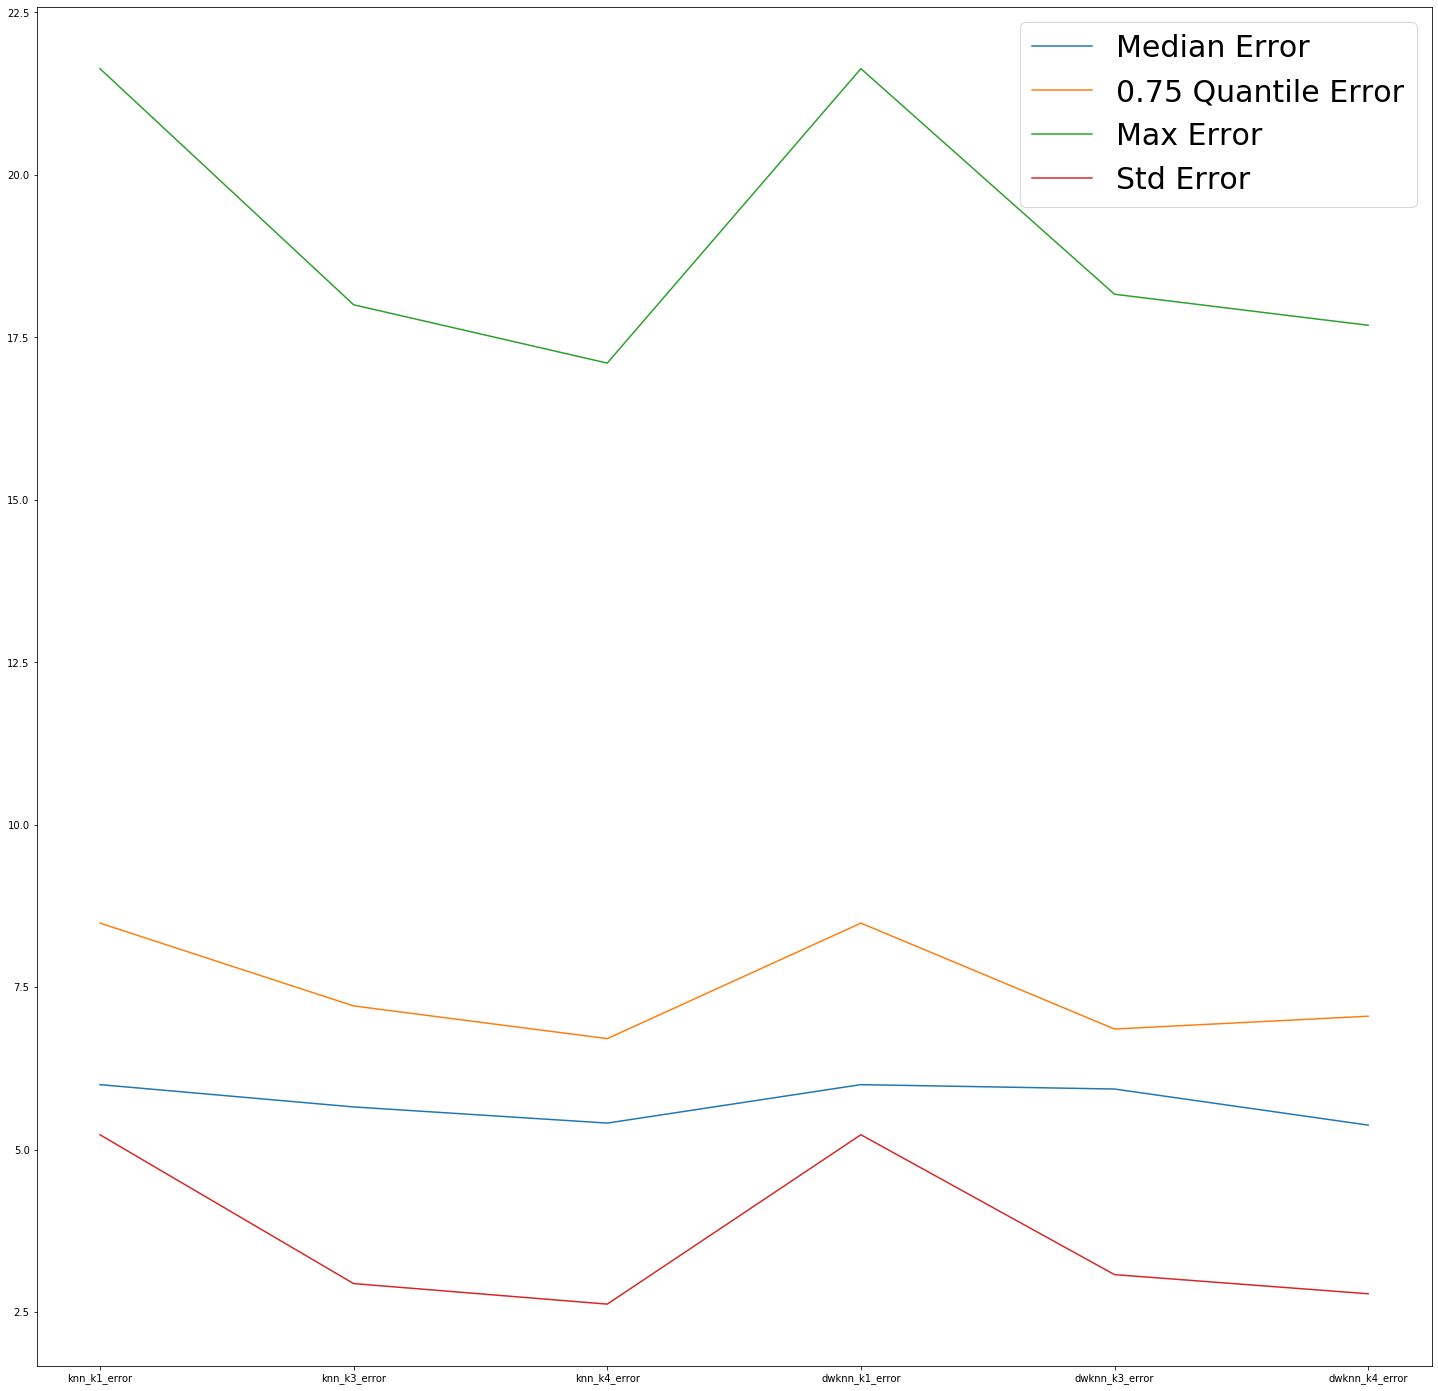

In [154]:
errorLine = ('E'+str(exp)+'_errorLine_T'+str(trial)+'.png')
plt.figure(figsize = (25,25))
print("Median Error:")
print(errorDf.median())
plt.plot(errorDf.median(), label = "Median Error")

print("\n0.75 Quantile Error:")
print(errorDf.quantile(0.75))
plt.plot(errorDf.quantile(0.75), label = "0.75 Quantile Error")

print("\nMax Error:")
print(errorDf.max())
plt.plot(errorDf.max(), label = "Max Error")

print("\nStd Error:")
print(errorDf.std())
plt.plot(errorDf.std(), label = "Std Error")

plt.legend(loc = 'best', fontsize = 30)
plt.savefig(errorLine)

In [155]:
# Create Error File
writeErrSumm = True
fileNameErrSumm = ('E'+str(exp)+'_ErrSummary_T'+str(trial)+'.csv')
meanErrArr = []
medianErrArr = []
quantErrArr = []
maxErrArr = []
stdDevArr = []
for series in errorDf:
    meanErrArr.append(errorDf[series].mean())
    medianErrArr.append(errorDf[series].median())
    quantErrArr.append(errorDf[series].quantile(0.75))
    maxErrArr.append(errorDf[series].max())
    stdDevArr.append(errorDf[series].std())
    
errorSummary = pd.DataFrame(index=range(0,len(errorDf.columns)))
errorSummary.insert(loc=0, column="Mean Error", value=meanErrArr)
errorSummary.insert(loc=1, column="Median Error", value=medianErrArr)
errorSummary.insert(loc=2, column="0.75 Quantile Error", value=quantErrArr)
errorSummary.insert(loc=3, column="Max Error", value=maxErrArr)
errorSummary.insert(loc=4, column="Std Error", value=stdDevArr)
algoType = ["knn_k"+str(kvalList[0]), "knn_k"+str(kvalList[1]), "knn_k"+str(kvalList[2]), 
#             "knn_k"+str(kvalList[3]),
                "dwknn_k"+str(kvalList[0]), "dwknn_k"+str(kvalList[1]), "dwknn_k"+str(kvalList[2]), 
#             "dwknn_k"+str(kvalList[3])
           ]

errorSummary.insert(loc=0, column="Algorithm", value = algoType)
print(errorSummary)


if (writeErrSumm == True):
    errorSummary.to_csv(fileNameErrSumm, index=False)
    print("File "+fileNameErrSumm+" has been written.")
# print(medianErrArr)

errorSummary.head(10)

  Algorithm  Mean Error  Median Error  0.75 Quantile Error  Max Error  \
0    knn_k1    5.534905      6.000000             8.485281  21.633308   
1    knn_k3    5.618232      5.656854             7.211103  18.000000   
2    knn_k4    5.594026      5.408327             6.708204  17.102631   
3  dwknn_k1    5.534905      6.000000             8.485281  21.633308   
4  dwknn_k3    5.665581      5.932296             6.855622  18.162123   
5  dwknn_k4    5.612176      5.377177             7.052724  17.684676   

   Std Error  
0   5.228867  
1   2.938561  
2   2.622576  
3   5.228867  
4   3.076499  
5   2.781871  
File E6_ErrSummary_T1.csv has been written.


,Algorithm,Mean Error,Median Error,0.75 Quantile Error,Max Error,Std Error
0,knn_k1,5.534905,6.000000,8.485281,21.633308,5.228867
1,knn_k3,5.618232,5.656854,7.211103,18.000000,2.938561
2,knn_k4,5.594026,5.408327,6.708204,17.102631,2.622576
3,dwknn_k1,5.534905,6.000000,8.485281,21.633308,5.228867
4,dwknn_k3,5.665581,5.932296,6.855622,18.162123,3.076499
5,dwknn_k4,5.612176,5.377177,7.052724,17.684676,2.781871


In [156]:
import seaborn as sns
import matplotlib.pyplot as plt

temp = errorSummary['Algorithm']
errorSummary = errorSummary.reset_index()
errorSummary = errorSummary.drop(columns=['Algorithm'])
errorSummary.index = temp
errorSummary = errorSummary.drop(columns=['index'])
errorSummary


,Mean Error,Median Error,0.75 Quantile Error,Max Error,Std Error
Algorithm,,,,,
knn_k1,5.534905,6.000000,8.485281,21.633308,5.228867
knn_k3,5.618232,5.656854,7.211103,18.000000,2.938561
knn_k4,5.594026,5.408327,6.708204,17.102631,2.622576
dwknn_k1,5.534905,6.000000,8.485281,21.633308,5.228867
dwknn_k3,5.665581,5.932296,6.855622,18.162123,3.076499
dwknn_k4,5.612176,5.377177,7.052724,17.684676,2.781871


<Figure size 432x288 with 0 Axes>

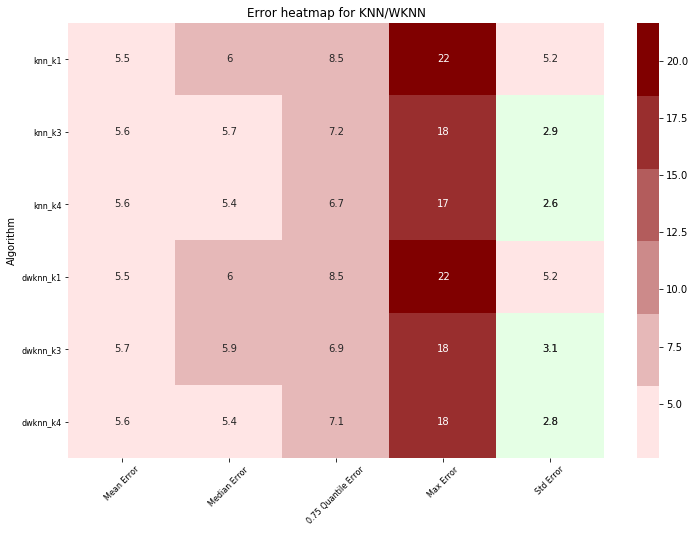

In [157]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
figName = ('E'+str(exp)+'_errorHeatMap_T'+str(trial)+'.png')
fig = plt.figure(facecolor='w', edgecolor='k')
fig =plt.figure(figsize=(12,8))
ax = plt.axes()
g = sns.heatmap(errorSummary, annot=True, cmap =sns.light_palette('maroon'))
sns.heatmap(errorSummary, mask= errorSummary > 5, annot=True, cmap=sns.light_palette('green'), cbar=False,
                ax = ax)
ax.set_title('Error heatmap for KNN/WKNN')
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 8)
g.set_yticklabels(g.get_yticklabels(), rotation = 0, fontsize = 8)
plt.savefig(figName)